In [2]:
import pickle
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn import svm
from sklearn.metrics import f1_score

from matplotlib import rcParams
rcParams['font.size'] = 14
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Definitions

In [2]:
num_tests = 50 # number of tests to be performed and obtain average accuracy
samples_normal = 100
samples_abnormal = 15

In [3]:
# DBSCAN definitions
epsilon_configurations = [.1, .5, 1., 2., 3., 4., 5., 10.]
min_samples_configurations = [3, 5, 8, 10, 12, 15, 20, 50, 80, 100]

In [4]:
# OC-SVM definitions
gammas = [0.001, 0.1, 0.2, 0.5, 0.7, 1.0]
kernels = ['rbf', 'linear', 'sigmoid'] # , 'poly'
nus = [0.01, 0.1, .3, .5, .7, 1.]

In [5]:
folder = '/nobackup/somelocation'

### Importing dataset

In [6]:
with open(folder + '/compiled-dataset.h5', 'rb') as file:
    final_dataframe, scaled_dataframe, class_columns, class_names = pickle.load(file)
input_dim = final_dataframe.shape[1] - 3 # the last three columns are classes

### Helper functions

In [10]:
# sort the OCSVM results dictionary by the performance
def get_sorted_pairs_ocsvm(performance):
    values = sorted([[performance[kernel][nu][gamma]['false_positive_rate'], performance[kernel][nu][gamma]['false_negative_rate']] for kernel in performance for nu in performance[kernel] for gamma in performance[kernel][nu]], key=lambda x: x[0])
    return values

# sort the DBSCAN results dictionary by the performance
def get_sorted_pairs_dbscan(performance):
    values = sorted([[performance[layer][epsilon]['false_positive_rate'], performance[layer][epsilon]['false_negative_rate']] for layer in performance for epsilon in performance[layer]], key=lambda x: x[0])
    return values

# get best OCSVM f1 score
def get_best_ocsvm(performance):
    best_f1 = .0
    best = None
    for kernel in performance.keys():
        for nu in performance[kernel].keys():
            for gamma in performance[kernel][nu].keys():
                if performance[kernel][nu][gamma]['f1_score'] > best_f1:
                    best_f1 = performance[kernel][nu][gamma]['f1_score']
                    best = performance[kernel][nu][gamma]
    return best

# get best DBSCAN f1 score
def get_best_dbscan(performance):
    best_f1 = .0
    best = None
    for min_samples in performance.keys():
        for epsilon in performance[min_samples].keys():
            if performance[min_samples][epsilon]['f1_score'] > best_f1:
                best_f1 = performance[min_samples][epsilon]['f1_score']
                best = performance[min_samples][epsilon]
    return best

def get_curve(sorted_pairs):
    curve_fpr = []
    curve_fnr = []

    last_x = sorted_pairs[0][0]
    last_y = sorted_pairs[0][1]

    curve_fpr.append(sorted_pairs[0][0])
    curve_fnr.append(sorted_pairs[0][1])
    
    for x, y in sorted_pairs:
        if x > curve_fpr[-1] and y < curve_fnr[-1]:
            curve_fpr.append(x)
            curve_fnr.append(y)
    return curve_fpr, curve_fnr

### Running DBSCAN

Here, we run DBSCAN for a set of different configurations and obtain the performance for each configuration.

In [8]:
performance_dbscan = {}
highest_f1 = 0.

for idm, min_samples in enumerate(min_samples_configurations):
    performance_dbscan[min_samples] = {}
    for ide, epsilon in enumerate(epsilon_configurations):
        performance_dbscan[min_samples][epsilon] = {}

print('MinPts\tepsilon\t\tfpr\tfnr\tf1')
for idm, min_samples in enumerate(min_samples_configurations):

    for ide, epsilon in enumerate(epsilon_configurations):

        clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')

        true_positives = []
        false_negatives = []
        true_negatives = []
        false_positives = []
        precisions = []
        recalls = []
        f1_scores = []

        for test in range(num_tests):
            p1 = scaled_dataframe[(scaled_dataframe['path_1'] == 1) & (scaled_dataframe['attack'] == 0)].sample(samples_normal)
            p2 = scaled_dataframe[(scaled_dataframe['path_2'] == 1) & (scaled_dataframe['attack'] == 0)].sample(samples_normal)
            x_data = np.concatenate((p1.values[:, :-3], p2.values[:, :-3]), axis=0)
            y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)

            # start copy
            for i in range(num_tests):
                x_data_test = np.copy(x_data)
                y_data_test = np.copy(y_data)
                for clazz in range(1, len(class_names)):
                    x = scaled_dataframe[(scaled_dataframe['path_1'] == 1) & (scaled_dataframe['attack'] == clazz)].sample(samples_abnormal)
                    x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                    y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                    x = scaled_dataframe[(scaled_dataframe['path_2'] == 1) & (scaled_dataframe['attack'] == clazz)].sample(samples_abnormal)
                    x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                    y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                y_pred = clf.fit_predict(x_data_test)

                tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                if tpr == 0: # avoids division by zero
                    precision = 0.
                    recall = 0.
                    f1 = 0.
                else:
                    precision = tpr / (tpr + fpr)
                    recall = tpr / (tpr + fnr)
                    f1 = 2 * precision * recall / (precision + recall)

                true_positives.append(tpr)
                false_negatives.append(fnr)
                true_negatives.append(tnr)
                false_positives.append(fpr)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)

        performance_dbscan[min_samples][epsilon]['min_samples'] = min_samples
        performance_dbscan[min_samples][epsilon]['epsilon'] = epsilon
            
        performance_dbscan[min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
        performance_dbscan[min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
        performance_dbscan[min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
        performance_dbscan[min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
        performance_dbscan[min_samples][epsilon]['precision'] = np.mean(precisions)
        performance_dbscan[min_samples][epsilon]['recall'] = np.mean(recalls)
        performance_dbscan[min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
        msg = ''
        if performance_dbscan[min_samples][epsilon]['f1_score'] > highest_f1:
            msg = '\t * highest'
            highest_f1 = performance_dbscan[min_samples][epsilon]['f1_score']
        print(f'{min_samples:>6}\t', f'{epsilon:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_dbscan[min_samples][epsilon]['false_positive_rate'],
                    performance_dbscan[min_samples][epsilon]['false_negative_rate'],
                    performance_dbscan[min_samples][epsilon]['f1_score']), msg)

print('done')

MinPts	epsilon		fpr	fnr	f1
     3	    0.1 	1.000	0.000	0.667	 	 * highest
     3	    0.5 	0.788	0.008	0.714	 	 * highest
     3	    1.0 	0.181	0.258	0.771	 	 * highest
     3	    2.0 	0.002	0.709	0.450	 
     3	    3.0 	0.000	0.849	0.261	 
     3	    4.0 	0.000	0.936	0.121	 
     3	    5.0 	0.000	0.967	0.063	 
     3	   10.0 	0.000	0.992	0.016	 
     5	    0.1 	1.000	0.000	0.667	 
     5	    0.5 	0.913	0.000	0.687	 
     5	    1.0 	0.264	0.154	0.802	 	 * highest
     5	    2.0 	0.001	0.678	0.486	 
     5	    3.0 	0.000	0.793	0.342	 
     5	    4.0 	0.000	0.910	0.165	 
     5	    5.0 	0.000	0.958	0.080	 
     5	   10.0 	0.000	0.991	0.018	 
     8	    0.1 	1.000	0.000	0.667	 
     8	    0.5 	0.969	0.000	0.674	 
     8	    1.0 	0.377	0.095	0.794	 
     8	    2.0 	0.002	0.660	0.507	 
     8	    3.0 	0.000	0.731	0.423	 
     8	    4.0 	0.000	0.860	0.244	 
     8	    5.0 	0.000	0.945	0.104	 
     8	   10.0 	0.000	0.991	0.019	 
    10	    0.1 	1.000	0.000	0.667	 
    10	    0.5 	0.977	0.000	0

### Running OCSVM

Here we run OCSVM for several different configurations and obtain the performance for each one of the configurations.

In [10]:
performance_ocsvm = {}
highest_f1 = .0

for kernel in kernels:
    performance_ocsvm[kernel] = {}
    for nu in nus:
        performance_ocsvm[kernel][nu] = {}
        for gamma in gammas:
            performance_ocsvm[kernel][nu][gamma] = {}

print('   kernel\t    nu\t gamma\t\tfpr\tfnr\tf1')
for kernel in kernels:
    for nu in nus:
        for gamma in gammas:

            clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
            true_positives = []
            false_negatives = []
            true_negatives = []
            false_positives = []
            precisions = []
            recalls = []
            f1_scores = []
            for i in range(num_tests):
                p1 = scaled_dataframe[(scaled_dataframe['path_1'] == 1) & (scaled_dataframe['attack'] == 0)].sample(samples_normal)
                p2 = scaled_dataframe[(scaled_dataframe['path_2'] == 1) & (scaled_dataframe['attack'] == 0)].sample(samples_normal)
                x_data = np.concatenate((p1.values[:, :-3], p2.values[:, :-3]), axis=0)
                y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)

                clf.fit(x_data)

                for test in range(num_tests):
                    x_data_test = np.copy(x_data)
                    y_data_test = np.copy(y_data)
                    for clazz in range(1, len(class_names)):
                        x = scaled_dataframe[(scaled_dataframe['path_1'] == 1) & (scaled_dataframe['attack'] == clazz)].sample(samples_abnormal)
                        x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                        y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                        x = scaled_dataframe[(scaled_dataframe['path_2'] == 1) & (scaled_dataframe['attack'] == clazz)].sample(samples_abnormal)
                        x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                        y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                    y_pred = clf.predict(x_data_test)

                    tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                    fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                    tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                    fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                    if tpr == 0: # avoids division by zero
                        precision = 0.
                        recall = 0.
                        f1 = 0.
                    else:
                        precision = tpr / (tpr + fpr)
                        recall = tpr / (tpr + fnr)
                        f1 = 2 * precision * recall / (precision + recall)

                    true_positives.append(tpr)
                    false_negatives.append(fnr)
                    true_negatives.append(tnr)
                    false_positives.append(fpr)
                    precisions.append(precision)
                    recalls.append(recall)
                    f1_scores.append(f1)

            performance_ocsvm[kernel][nu][gamma]['kernel'] = kernel
            performance_ocsvm[kernel][nu][gamma]['nu'] = nu
            performance_ocsvm[kernel][nu][gamma]['gamma'] = gamma
                
            performance_ocsvm[kernel][nu][gamma]['true_positive_rate'] = np.mean(true_positives)
            performance_ocsvm[kernel][nu][gamma]['false_negative_rate'] = np.mean(false_negatives)
            performance_ocsvm[kernel][nu][gamma]['true_negative_rate'] = np.mean(true_negatives)
            performance_ocsvm[kernel][nu][gamma]['false_positive_rate'] = np.mean(false_positives)
            performance_ocsvm[kernel][nu][gamma]['precision'] = np.mean(precisions)
            performance_ocsvm[kernel][nu][gamma]['recall'] = np.mean(recalls)
            performance_ocsvm[kernel][nu][gamma]['f1_score'] = np.mean(f1_scores)
            msg = ''
            if performance_ocsvm[kernel][nu][gamma]['f1_score'] > highest_f1:
                msg = '\t * highest'
                highest_f1 = performance_ocsvm[kernel][nu][gamma]['f1_score']
            print(f'{kernel:>10}\t', f'{nu:>6}\t', f'{gamma:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_ocsvm[kernel][nu][gamma]['false_positive_rate'],
                        performance_ocsvm[kernel][nu][gamma]['false_negative_rate'],
                        performance_ocsvm[kernel][nu][gamma]['f1_score']), msg)
print('done')

   kernel	    nu	 gamma		fpr	fnr	f1
       rbf	   0.01	  0.001 	0.009	0.571	0.591	 	 * highest
       rbf	   0.01	    0.1 	0.049	0.245	0.837	 	 * highest
       rbf	   0.01	    0.2 	0.078	0.152	0.880	 	 * highest
       rbf	   0.01	    0.5 	0.166	0.029	0.909	 	 * highest
       rbf	   0.01	    0.7 	0.223	0.010	0.895	 
       rbf	   0.01	    1.0 	0.289	0.002	0.873	 
       rbf	    0.1	  0.001 	0.099	0.358	0.737	 
       rbf	    0.1	    0.1 	0.103	0.205	0.838	 
       rbf	    0.1	    0.2 	0.111	0.146	0.869	 
       rbf	    0.1	    0.5 	0.164	0.027	0.910	 	 * highest
       rbf	    0.1	    0.7 	0.218	0.010	0.897	 
       rbf	    0.1	    1.0 	0.282	0.002	0.876	 
       rbf	    0.3	  0.001 	0.298	0.258	0.727	 
       rbf	    0.3	    0.1 	0.299	0.090	0.824	 
       rbf	    0.3	    0.2 	0.300	0.069	0.834	 
       rbf	    0.3	    0.5 	0.302	0.022	0.858	 
       rbf	    0.3	    0.7 	0.304	0.010	0.863	 
       rbf	    0.3	    1.0 	0.312	0.002	0.864	 
       rbf	    0.5	  0.001 	0.501	0.185	0.704

### Comparing DBSCAN and OCSVM

In [12]:
# here we save the performance

# with open('./models/raw-ds-results.h5', 'wb') as file:
#     pickle.dump({
#         'performance_ocsvm': performance_ocsvm,
#         'performance_dbscan': performance_dbscan
#     }, file)

In [24]:
# here we open the file with the performance of the models

with open('./models/raw-ds-results.h5', 'rb') as file:
    perf_dict = pickle.load(file)
    performance_ocsvm = perf_dict['performance_ocsvm']
    performance_dbscan = perf_dict['performance_dbscan']

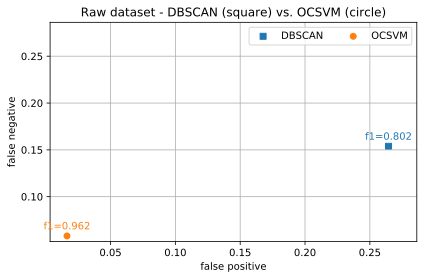

In [23]:
plt.figure()# figsize=(10, 8)

    
best_f1_dbscan = get_best_dbscan(performance_dbscan)
ax = plt.scatter(best_f1_dbscan['false_positive_rate'], best_f1_dbscan['false_negative_rate'], marker='s', label='DBSCAN')
plt.annotate(f"f1={best_f1_dbscan['f1_score']:.3f}", xy=(best_f1_dbscan['false_positive_rate'], best_f1_dbscan['false_negative_rate']+.01), 
             color=ax.get_facecolors()[0], va='center', ha='center')
    
best_f1_ocsvm = get_best_ocsvm(performance_ocsvm)
ax = plt.scatter(best_f1_ocsvm['false_positive_rate'], best_f1_ocsvm['false_negative_rate'], marker='o', label='OCSVM')
plt.annotate(f"f1={best_f1_ocsvm['f1_score']:.3f}", xy=(best_f1_ocsvm['false_positive_rate'], best_f1_ocsvm['false_negative_rate']+.01), 
             color=ax.get_facecolors()[0], va='center', ha='center')
    
plt.title('Raw dataset - DBSCAN (square) vs. OCSVM (circle)')
plt.xlabel('false positive')
plt.ylabel('false negative')
x_lim = plt.xlim()
y_lim = plt.ylim()
plt.grid()
plt.xlim(x_lim[0], max(x_lim[1], y_lim[1]))
plt.ylim(y_lim[0], max(x_lim[1], y_lim[1]))
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('./figures/raw_ds_summary.pdf')
plt.savefig('./figures/raw_ds_summary.svg')
plt.show()